In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math


The assumed overfill is 10%.
The mean expected payout is $464.3 ($19.1 from budget).
The maximum expected payout is $474.8 ($8.6 from budget).
The minimum expected payout is $453.9 ($29.5 from budget).


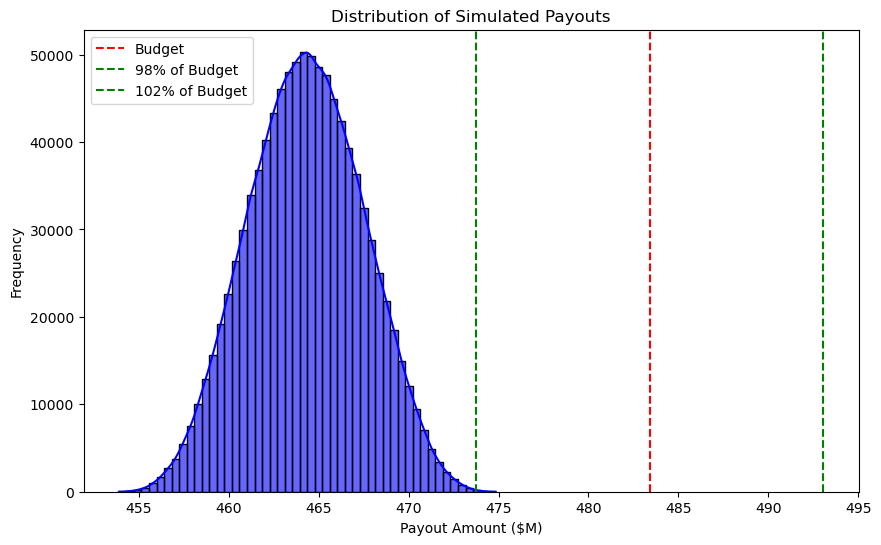

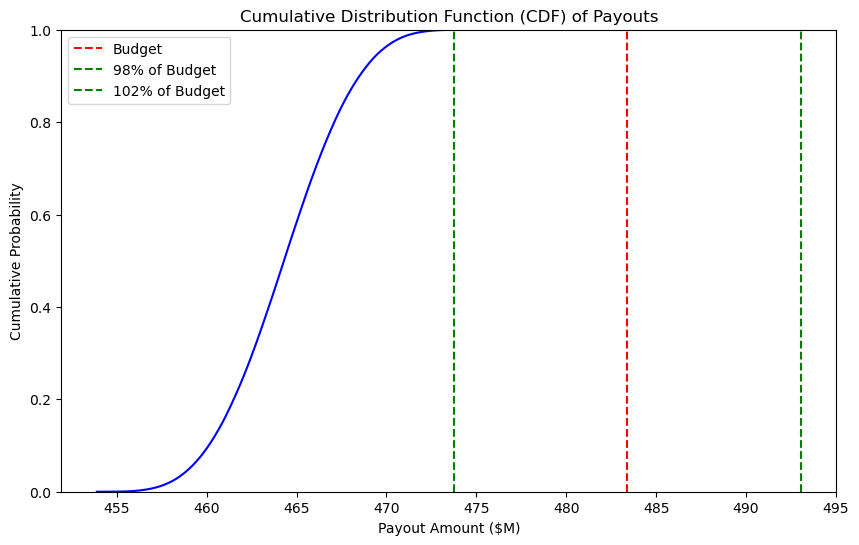


Overfill Sensitivity Analysis - Probability Within Budget:

 Overfill  Probability Within Budget Range
     0.00                         0.000000
     0.05                         0.000000
     0.10                         0.000152
     0.15                         0.284252
     0.20                         0.961980
     0.25                         0.814230
     0.30                         0.037744
     0.35                         0.000000
     0.40                         0.000000
     0.45                         0.000000
     0.50                         0.000000

Overfill Sensitivity Analysis - Mean Payout:

 Overfill  Mean Payout ($M)
     0.00        451.692266
     0.05        457.668852
     0.10        464.304944
     0.15        471.719969
     0.20        480.069122
     0.25        489.520596
     0.30        500.331609
     0.35        512.819630
     0.40        527.348410
     0.45        544.560357
     0.50        565.185763


In [2]:
# Input variables
budget = 483.4
gavi = 329.5
paid = 8.7
subs = 65.4
initial = 1.4
contracts = 16.8
new = budget - gavi - paid - subs - initial - contracts

# Sensitivity range for overfill
overfill_values = np.linspace(0, 0.5, 11)  # From 0% to 50% overfill
sims = 1000000

# Attrition ranges
subs_attrit_low, subs_attrit_high = 0.08, 0.18
init_attrit_low, init_attrit_high = 0.01, 0.02
contr_attrit_low, contr_attrit_high = 0.12, 0.22
new_attrit_low, new_attrit_high = 0.23, 0.43

# Use midpoint as the most likely (mode) for triangle distribution
subs_mode = (subs_attrit_low + subs_attrit_high) / 2
init_mode = (init_attrit_low + init_attrit_high) / 2
contr_mode = (contr_attrit_low + contr_attrit_high) / 2
new_mode = (new_attrit_low + new_attrit_high) / 2

# Probability range for being "on budget"
between_low = budget * 0.98
between_high = budget * 1.02

# Storage for sensitivity analysis
sensitivity_results = []
sensitivity_mean_results = []

# Run sensitivity simulation
for overfill in overfill_values:
    subs_simulated = (subs / (1 - overfill)) * (1 - np.random.triangular(subs_attrit_low, subs_mode, subs_attrit_high, sims))
    init_simulated = (initial / (1 - overfill)) * (1 - np.random.triangular(init_attrit_low, init_mode, init_attrit_high, sims))
    contr_simulated = (contracts / (1 - overfill)) * (1 - np.random.triangular(contr_attrit_low, contr_mode, contr_attrit_high, sims))
    new_simulated = (new / (1 - overfill)) * (1 - np.random.triangular(new_attrit_low, new_mode, new_attrit_high, sims))

    payout_simulated = gavi + paid + subs_simulated + init_simulated + contr_simulated + new_simulated

    prob_between = np.sum((payout_simulated > between_low) & (payout_simulated < between_high)) / sims
    mean_payout = np.mean(payout_simulated)

    sensitivity_results.append([overfill, prob_between])
    sensitivity_mean_results.append([overfill, mean_payout])

# Convert results to DataFrames
df_sensitivity = pd.DataFrame(sensitivity_results, columns=["Overfill", "Probability Within Budget Range"])
df_sensitivity_mean = pd.DataFrame(sensitivity_mean_results, columns=["Overfill", "Mean Payout ($M)"])

# Function to display nicely in terminal
def display_dataframe(name, dataframe):
    print(f"\n{name}:\n")
    print(dataframe.to_string(index=False))

# Run one simulation for visualization
overfill = 0.10  # Example level
subs_simulated = (subs / (1 - overfill)) * (1 - np.random.triangular(subs_attrit_low, subs_mode, subs_attrit_high, sims))
init_simulated = (initial / (1 - overfill)) * (1 - np.random.triangular(init_attrit_low, init_mode, init_attrit_high, sims))
contr_simulated = (contracts / (1 - overfill)) * (1 - np.random.triangular(contr_attrit_low, contr_mode, contr_attrit_high, sims))
new_simulated = (new / (1 - overfill)) * (1 - np.random.triangular(new_attrit_low, new_mode, new_attrit_high, sims))

payout_simulated = gavi + paid + subs_simulated + init_simulated + contr_simulated + new_simulated

# Headline stats
mean_payout = np.mean(payout_simulated)
max_payout = np.max(payout_simulated)
min_payout = np.min(payout_simulated)

print(f"\nThe assumed overfill is {overfill:.0%}.")
print(f"The mean expected payout is ${mean_payout:,.1f} (${(budget - mean_payout):,.1f} from budget).")
print(f"The maximum expected payout is ${max_payout:,.1f} (${(budget - max_payout):,.1f} from budget).")
print(f"The minimum expected payout is ${min_payout:,.1f} (${(budget - min_payout):,.1f} from budget).")

# Histogram
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(payout_simulated, bins=50, kde=True, color="blue", alpha=0.6, ax=ax)
ax.axvline(budget, color="red", linestyle="--", label="Budget")
ax.axvline(between_low, color="green", linestyle="--", label="98% of Budget")
ax.axvline(between_high, color="green", linestyle="--", label="102% of Budget")
ax.set_title("Distribution of Simulated Payouts")
ax.set_xlabel("Payout Amount ($M)")
ax.set_ylabel("Frequency")
ax.legend()
plt.savefig("histogram.png", dpi=300, bbox_inches='tight')
plt.show()

# CDF Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.ecdfplot(payout_simulated, color="blue", ax=ax)
ax.axvline(budget, color="red", linestyle="--", label="Budget")
ax.axvline(between_low, color="green", linestyle="--", label="98% of Budget")
ax.axvline(between_high, color="green", linestyle="--", label="102% of Budget")
ax.set_title("Cumulative Distribution Function (CDF) of Payouts")
ax.set_xlabel("Payout Amount ($M)")
ax.set_ylabel("Cumulative Probability")
ax.legend()
plt.savefig("cdf.png", dpi=300, bbox_inches='tight')
plt.show()

# Show summary tables
display_dataframe("Overfill Sensitivity Analysis - Probability Within Budget", df_sensitivity)
display_dataframe("Overfill Sensitivity Analysis - Mean Payout", df_sensitivity_mean)